### Network Analysis

Notebook for quick sanity checks and plots of a solved PyPSA-Earth network.

### Sync a solved network (from repo root)

```bash
rsync -avz --progress \
  engs2523@arc-login.arc.ox.ac.uk:/data/engs-df-green-ammonia/engs2523/pypsa-earth/results/<run-name>/networks/<network-file>.nc \
  results/<run-name>/networks/
```
Then update `RESULT_PATH` in the next cell to point at the downloaded file.

In [1]:
# Download natura raster on first run
import cartopy; from cartopy import feature as cf
cf.NaturalEarthFeature("physical","land","10m")

In [1]:
from pathlib import Path

# Solved network file path (absolute)
RESULT_PATH = Path('/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/results/arc/europe-day-core-tech/networks/elec_s_70_ec_lcopt_Co2L-3h.nc')

if not RESULT_PATH.exists():
    raise FileNotFoundError(
        f"Solved network missing at {RESULT_PATH}. Update RESULT_PATH or sync the file first."
    )
print('Using network file:', RESULT_PATH.resolve())

Using network file: /Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/results/arc/europe-day-core-tech/networks/elec_s_70_ec_lcopt_Co2L-3h.nc


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import pypsa
except ImportError as exc:
    raise SystemExit('PyPSA missing. Install via mamba install -c conda-forge pypsa') from exc

try:
    import cartopy  # noqa: F401
    CARTOPY_AVAILABLE = True
except Exception:
    CARTOPY_AVAILABLE = False

print('PyPSA version:', pypsa.__version__)
print('Cartopy available:', CARTOPY_AVAILABLE)

PyPSA version: 0.28.0
Cartopy available: True


In [3]:
n = pypsa.Network(str(RESULT_PATH))
print(n)
print('Snapshots:', list(n.snapshots))
print('Buses:', len(n.buses), 'Lines:', len(n.lines), 'Generators:', len(n.generators))

INFO:pypsa.io:Imported network elec_s_70_ec_lcopt_Co2L-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


PyPSA Network
Components:
 - Bus: 210
 - Carrier: 24
 - Generator: 273
 - GlobalConstraint: 1
 - Line: 22
 - Link: 362
 - Load: 49
 - StorageUnit: 37
 - Store: 140
Snapshots: 2920
Snapshots: [Timestamp('2013-01-01 00:00:00'), Timestamp('2013-01-01 03:00:00'), Timestamp('2013-01-01 06:00:00'), Timestamp('2013-01-01 09:00:00'), Timestamp('2013-01-01 12:00:00'), Timestamp('2013-01-01 15:00:00'), Timestamp('2013-01-01 18:00:00'), Timestamp('2013-01-01 21:00:00'), Timestamp('2013-01-02 00:00:00'), Timestamp('2013-01-02 03:00:00'), Timestamp('2013-01-02 06:00:00'), Timestamp('2013-01-02 09:00:00'), Timestamp('2013-01-02 12:00:00'), Timestamp('2013-01-02 15:00:00'), Timestamp('2013-01-02 18:00:00'), Timestamp('2013-01-02 21:00:00'), Timestamp('2013-01-03 00:00:00'), Timestamp('2013-01-03 03:00:00'), Timestamp('2013-01-03 06:00:00'), Timestamp('2013-01-03 09:00:00'), Timestamp('2013-01-03 12:00:00'), Timestamp('2013-01-03 15:00:00'), Timestamp('2013-01-03 18:00:00'), Timestamp('2013-01-03 21:0

## Installed capacities (MW)

In [4]:
cap_by_carrier = n.generators.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
cap_df = cap_by_carrier.to_frame(name='p_nom_MW')
cap_df

,p_nom_MW
carrier,
solar,221577.142187
onwind,188791.493400
CCGT,167746.088572
nuclear,109630.518175
coal,81651.454432
lignite,61344.149045
oil,32766.821202
ror,32542.295985
offwind-dc,25911.068744


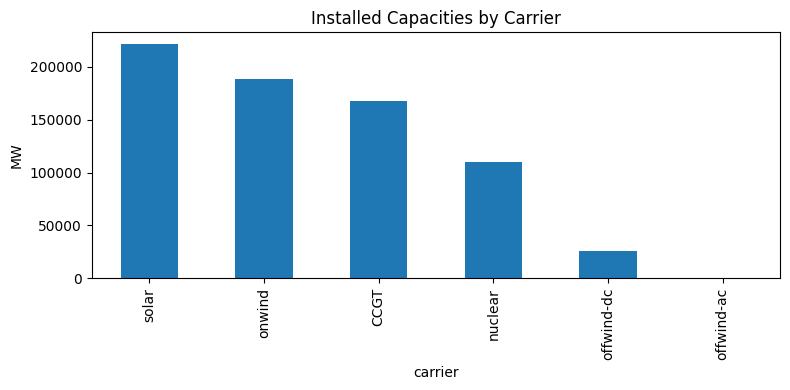

In [6]:
ax = cap_by_carrier.plot(kind='bar', figsize=(8, 4), title='Installed Capacities by Carrier')
ax.set_ylabel('MW')
plt.tight_layout()
plt.show()

## Generation mix (snapshot 0)

In [5]:
snap = n.snapshots[0]
tech_mix = n.generators_t.p.loc[snap].groupby(n.generators['carrier']).sum().sort_values(ascending=False)
tech_mix

Series([], Name: 2013-01-01 00:00:00, dtype: float64)

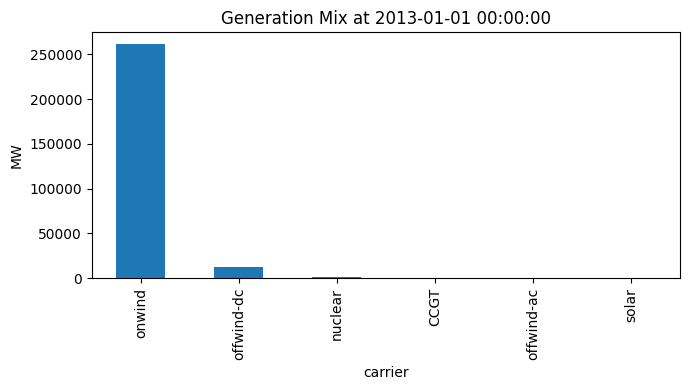

In [8]:
tech_mix.plot(kind='bar', figsize=(7, 4), title=f'Generation Mix at {snap}')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

## Simple network map

/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


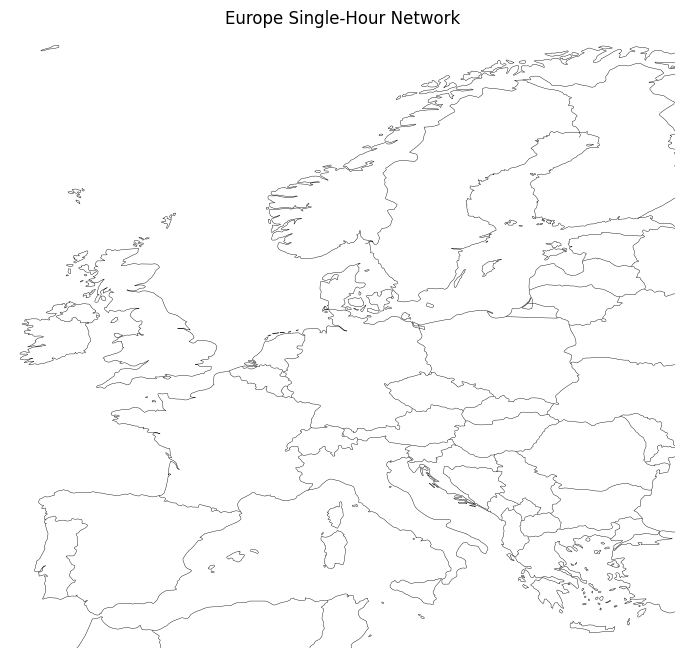

In [6]:
if CARTOPY_AVAILABLE:
    try:
        import cartopy.crs as ccrs
        plt.close("all")  # avoid reusing stale GeoAxes when re-running the cell
        fig, ax = plt.subplots(figsize=(9, 8), subplot_kw={"projection": ccrs.PlateCarree()})
        # scale factors tuned for visibility (increase if map still sparse)
        bus_sizes = (
            5e-5  # adjust this multiplier to grow/shrink bus bubbles
            * n.loads.groupby("bus").p_set.max().reindex(n.buses.index).fillna(0.0)
        )
        line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)  # increase for thicker AC lines
        link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)  # increase for thicker DC links

        n.plot(
            ax=ax,
            boundaries=(-11, 30, 34, 72),
            title="Europe Single-Hour Network",
            bus_sizes=bus_sizes,
            bus_colors="tab:orange",
            line_widths=line_widths,
            line_colors="steelblue",
            link_widths=link_widths,
            link_colors="slategray",
            branch_components={"Line", "Link"},
        )
        plt.show()
    except Exception as exc:
        print("Map plotting failed:", exc)
else:
    print("Cartopy not available; skipping geographic map.")

## Bus-level generation pies (snapshot 0)

/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


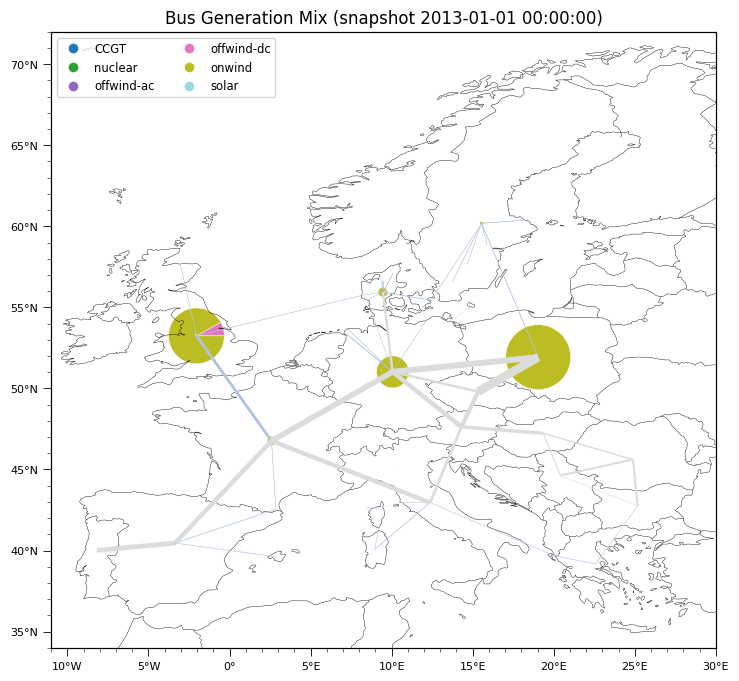

In [10]:
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

if CARTOPY_AVAILABLE and not n.generators_t.p.empty:
    gen_flow = n.generators_t.p.loc[snap]
    if gen_flow.abs().sum() == 0:
        print("Generator dispatch is zero at this snapshot; check that you're loading the solved network.")
    else:
        meta = n.generators[["bus", "carrier"]]
        df = pd.DataFrame({"p": gen_flow, "bus": meta.bus, "carrier": meta.carrier})
        pies = df.pivot_table(index="bus", columns="carrier", values="p", aggfunc="sum").fillna(0.0)
        pies = pies[pies.sum(axis=1) > 0]
        if len(pies) == 0:
            print("No generation at snapshot to plot pies.")
        else:
            from matplotlib.patches import Wedge

            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
            # tweak multipliers below to scale AC line and DC link thickness in the background map
            line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)
            link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)
            try:
                n.plot(
                    ax=ax,
                    boundaries=(-11, 30, 34, 72),
                    bus_sizes=0.0,
                    line_widths=line_widths,
                    line_colors="gainsboro",
                    link_widths=link_widths,
                    link_colors="lightsteelblue",
                    branch_components={"Line", "Link"},
                )
            except Exception as exc:
                print("n.plot failed; falling back to plain coastlines:", exc)
                ax.set_extent((-11, 30, 34, 72))
                ax.coastlines()
            carriers = pies.columns.tolist()
            colors = plt.cm.tab20(np.linspace(0, 1, len(carriers)))
            color_map = dict(zip(carriers, colors))
            max_total = pies.sum(axis=1).max()
            r_scale = 2.0 / max_total if max_total > 0 else 0.0  # adjust numerator for larger/smaller pies
            for bus, row in pies.iterrows():
                x = n.buses.loc[bus, "x"]
                y = n.buses.loc[bus, "y"]
                total = row.sum()
                if total <= 0:
                    continue
                start = 0.0
                radius = total * r_scale
                for carrier in carriers:
                    val = row.get(carrier, 0.0)
                    if val <= 0:
                        continue
                    angle = 360 * val / total
                    wedge = Wedge((x, y), radius, start, start + angle, facecolor=color_map[carrier], edgecolor="white", linewidth=0.3)
                    ax.add_patch(wedge)
                    start += angle
            legend_handles = [
                plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[c], label=c, markersize=8)
                for c in carriers
            ]
            ax.legend(handles=legend_handles, loc="upper left", fontsize="small", ncol=2, frameon=True)

            ax.set_axis_on()
            for spine in ax.spines.values():
                spine.set_visible(True)
            ax.set_xlim(-11, 30)
            ax.set_ylim(34, 72)

            major_xticks = np.arange(-10, 31, 5)
            major_yticks = np.arange(35, 73, 5)
            ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
            ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(LongitudeFormatter())
            ax.yaxis.set_major_formatter(LatitudeFormatter())
            ax.tick_params(axis="both", which="major", labelsize=8, length=6, width=0.6, direction="out")
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
            ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
            ax.tick_params(axis="both", which="minor", length=3, width=0.4, direction="out")

            ax.set_title(f"Bus Generation Mix (snapshot {snap})")
            plt.show()
elif not CARTOPY_AVAILABLE:
    print("Cartopy not available; skipping pie map.")
else:
    print("No generator dispatch stored in this network file. Sync the solved network (elec_s_140...).")

## Line loading distribution

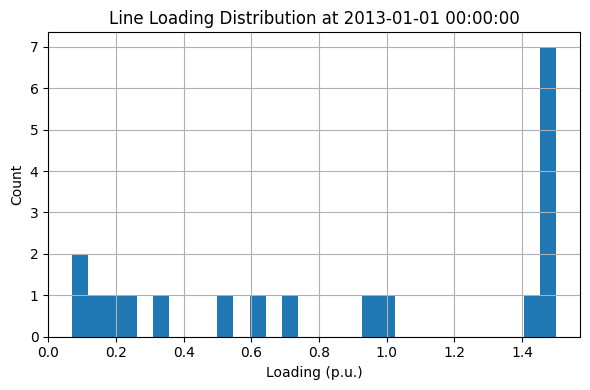

In [11]:
if 'p0' in n.lines_t:
    loading = (n.lines_t.p0.loc[snap].abs() / n.lines.s_nom).fillna(0.0)
    plt.figure(figsize=(6, 4))
    loading.clip(upper=1.5).hist(bins=30)
    plt.title(f'Line Loading Distribution at {snap}')
    plt.xlabel('Loading (p.u.)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('Line flow results missing in network file.')

## Marginal prices

In [12]:
if 'marginal_price' in n.buses_t:
    prices = n.buses_t.marginal_price.loc[snap].dropna().sort_values(ascending=False)
    price_table = pd.DataFrame({
        'bus': prices.index,
        'price_EUR_per_MWh': prices.values
    })
    price_table.head(10)
else:
    print('No marginal prices stored in buses_t.')

## Objective value and cost breakdown

In [13]:
if hasattr(n, 'objective'):
    total_obj = float(n.objective / 1e6)
    print(f'Total objective: {total_obj:.2f} million EUR')
else:
    print('Objective attribute missing; using cost components only.')

gen_nom = n.generators.get('p_nom_opt', n.generators['p_nom'])
capex_gen = (gen_nom * n.generators.get('capital_cost', 0.0)).sum()

if len(n.stores):
    store_nom = n.stores.get('e_nom_opt', n.stores['e_nom'])
    capex_store = (store_nom * n.stores.get('capital_cost', 0.0)).sum()
else:
    capex_store = 0.0

if 'capital_cost' in n.lines.columns:
    line_nom = n.lines.get('s_nom_opt', n.lines['s_nom'])
    capex_lines = (line_nom * n.lines['capital_cost']).sum()
else:
    capex_lines = 0.0

operating_costs = (n.objective - (capex_gen + capex_store + capex_lines)) if hasattr(n, 'objective') else float('nan')

pd.Series({
    'generator_capex_EUR': capex_gen,
    'storage_capex_EUR': capex_store,
    'line_capex_EUR': capex_lines,
    'operating_costs_EUR': operating_costs
}) / 1e6

Total objective: 1391198.89 million EUR


generator_capex_EUR    1.632567e+05
storage_capex_EUR      1.849467e+04
line_capex_EUR         1.234473e+04
operating_costs_EUR    1.197103e+06
dtype: float64

In [14]:
co2_constraints = n.global_constraints[n.global_constraints.index.str.contains('co2', case=False)]
if co2_constraints.empty:
    display(n.global_constraints)
    print("No CO2-labeled global constraint found; above shows all available constraints.")
else:
    display(co2_constraints[[c for c in co2_constraints.columns if c not in {'carrier_attribute'}]])
    if 'sense' in co2_constraints.columns and 'constant' in co2_constraints.columns:
        for name, row in co2_constraints.iterrows():
            print(f"Constraint {name}: {row['sense']} {row['constant']:.2f} tCO2")

carrier_emissions = n.carriers.get('co2_emissions')
if carrier_emissions is None or carrier_emissions.isnull().all():
    print("Carrier sheet lacks co2_emissions values; cannot compute realised emissions.")
else:
    def component_emissions(power_df, component_df):
        if power_df is None or power_df.empty:
            return 0.0
        factors = component_df['carrier'].map(carrier_emissions).fillna(0.0)
        return power_df.mul(factors, axis=1).sum().sum()

    gen_emissions = component_emissions(n.generators_t.p, n.generators)
    link_emissions = component_emissions(getattr(n.links_t, 'p0', None), n.links)
    store_emissions = component_emissions(getattr(n.stores_t, 'p', None), n.stores)
    total_operational_co2 = gen_emissions + link_emissions + store_emissions
    print(f"Realised operational CO2: {total_operational_co2:.2f} tCO2")


,sense,constant,mu,type,investment_period
GlobalConstraint,,,,,
CO2Limit,<=,77500000.0,-27.193459,primary_energy,NaN


Constraint CO2Limit: <= 77500000.00 tCO2
Realised operational CO2: 625.37 tCO2


## Notes
- Extend to longer horizons or additional carriers via `config/default-single-timestep.yaml`.
- Add further aggregation cells (country mix, storage flows, etc.) as needed.

In [15]:
import pypsa
n_diag = pypsa.Network(RESULT_PATH)
assert n_diag.buses[['x','y']].notna().all().all()

       'AT38 0 load shedding', 'AT38 0 ror', 'BG0 0 coal', 'BG0 0 lignite',
       'BG0 0 load shedding', 'BG0 0 ror',
       ...
       'RS19 0 load shedding', 'SE4 0 biomass', 'SE4 0 load shedding',
       'SE4 0 oil', 'SE4 0 ror', 'SE43 0 biomass', 'SE43 0 load shedding',
       'SE43 0 oil', 'SE43 0 ror', 'SE5 0 load shedding'],
      dtype='str', name='Generator', length=135) for attribute p of Generator are not in main components dataframe generators
       'DE0 0 hydro', 'ES0 0 hydro', 'FR0 0 hydro', 'FR13 0 hydro',
       'GB16 0 hydro', 'GR0 0 hydro', 'HU0 0 hydro', 'IT0 0 hydro',
       'IT39 0 hydro', 'PL0 0 hydro', 'PT0 0 hydro', 'RO0 0 hydro',
       'RS0 0 hydro', 'SE4 0 hydro', 'SE43 0 hydro'],
      dtype='str', name='StorageUnit') for attribute p of StorageUnit are not in main components dataframe storage_units
       'DE0 0 hydro', 'ES0 0 hydro', 'FR0 0 hydro', 'FR13 0 hydro',
       'GB16 0 hydro', 'GR0 0 hydro', 'HU0 0 hydro', 'IT0 0 hydro',
       'IT39 0 hydro', '

In [16]:
line_widths_raw = n_diag.lines.s_nom_opt.fillna(n_diag.lines.s_nom)
print("Lines with zero rating:", (line_widths_raw <= 0).sum(), " / ", len(line_widths_raw))
print("Bus coords missing:", n_diag.buses[['x','y']].isna().any(axis=1).sum())
if hasattr(n_diag, 'loads_t') and 'p_set' in n_diag.loads_t:
    peak_loads = n_diag.loads_t.p_set.max()  # per-load max over snapshots
    load_per_bus = peak_loads.groupby(n_diag.loads.loc[peak_loads.index, 'bus']).sum()
    print("Peak load per bus summary (MW):")
    print(load_per_bus.describe())
else:
    print("Load time series missing; confirm you're opening the solved network export.")

Lines with zero rating: 0  /  19
Bus coords missing: 0
Peak load per bus summary (MW):
count       49.000000
mean      8476.307774
std      18699.768064
min          0.672660
25%         51.662841
50%        739.914378
75%       6555.674460
max      86002.016990
dtype: float64


In [8]:
# Check clustering: nodes per country
import pandas as pd
import re

# Extract country from bus name - format is like "AT0 0", "IT0 0 H2", "SE46 0"
buses_df = pd.DataFrame({'bus': n.buses.index})
buses_df['country'] = buses_df['bus'].apply(lambda x: re.match(r'([A-Z]{2})\d+', str(x)).group(1) if re.match(r'([A-Z]{2})', str(x)) else 'UNK')
nodes_per_country = buses_df.groupby('country')['bus'].count().sort_values(ascending=False)

print(f"\nNetwork Summary:")
print(f"  Total buses: {len(n.buses)}")
print(f"  Total clusters: {len(nodes_per_country)}")
print(f"  Generators: {len(n.generators)}")
print(f"  Snapshots: {len(n.snapshots)}")
print(f"\nNodes per country:")
print(nodes_per_country)
print(f"\n✓ CRITICAL CHECK: Sweden (SE) has {nodes_per_country.get('SE', 0)} node(s) [expected: 1]")


Network Summary:
  Total buses: 210
  Total clusters: 16
  Generators: 273
  Snapshots: 2920

Nodes per country:
country
DK    48
DE    27
FR    21
GB    18
SE    18
GR    15
IT    12
ES     9
AT     6
CZ     6
PL     6
PT     6
RO     6
RS     6
BG     3
HU     3
Name: bus, dtype: int64

✓ CRITICAL CHECK: Sweden (SE) has 18 node(s) [expected: 1]
